In [1]:
import time
import os
import pyvisa
import serial # if the module is not present you need to instal pyserial
import serial.tools.list_ports
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from VotschTechnikClimateChamber.ClimateChamber import ClimateChamber
from alive_progress import alive_bar
from datetime import datetime

%matplotlib notebook

In [19]:
def runtest(save=False):
    #Global variables that correspond to those in the arduino
    HANDSHAKE = 0
    TEMP_REQUEST = 1
    
    def get_timestamp():
        current_time=datetime.now()
        timestamp=current_time.timestamp()
        date_time=datetime.fromtimestamp(timestamp)
        str_date_time=date_time.strftime("%H:%M:%S")
        return str_date_time,current_time.time()
    
    #Connectivity functions
    def find_arduino(port=None):
        """Get the name of the port that is connected to Arduino."""
        if port is None:
            ports = serial.tools.list_ports.comports()
            for p in ports:
                if p.manufacturer is not None and "Arduino" in p.manufacturer:
                    port = p.device
        return port


    def handshake_arduino(
        arduino, sleep_time=1, print_handshake_message=False, handshake_code=0
    ):
        """Make sure connection is established by sending
        and receiving bytes."""
        # Close and reopen
        arduino.close()
        arduino.open()

        # Chill out while everything gets set
        time.sleep(sleep_time)

        # Set a long timeout to complete handshake
        timeout = arduino.timeout
        arduino.timeout = 2

        # Read and discard everything that may be in the input buffer
        _ = arduino.read_all()

        # Send request to Arduino
        arduino.write(bytes([handshake_code]))

        # Read in what Arduino sent
        handshake_message = arduino.read_until()

        # Send and receive request again
        arduino.write(bytes([handshake_code]))
        handshake_message = arduino.read_until()

        # Print the handshake message, if desired
        if print_handshake_message:
            print("Handshake message: " + handshake_message.decode())

        # Reset the timeout
        arduino.timeout = timeout
    

    port = find_arduino()
    arduino = serial.Serial(port, baudrate=115200)
    #Establish handshake with arduino
    handshake_arduino(arduino, handshake_code=HANDSHAKE, print_handshake_message=True)
    time.sleep(10)

    #Parsing and request functions
    def parse_raw(raw):
        """Parse bytes output from Arduino."""
        raw = raw.decode()
        if raw[-1] != "\n":
            raise ValueError(
                "Input must end with newline, otherwise message is incomplete."
            )
        t = raw.rstrip()
        return float(t)

    def request_single_temp(arduino):
        """Ask Arduino for a single data point"""
        # Ask Arduino for data
        arduino.write(bytes([TEMP_REQUEST]))

        # Read in the data
        raw = arduino.read_until()

        # Parse and return
        return parse_raw(raw)
    try:
        if save:
            TestName=input("Test name:\n")
            filename=TestName + '/' + "results_pressure.txt"
            try:
                os.mkdir(TestName)
            except:
                os.mkdir(TestName)
            fileID=open(filename,'w')
            fileID.write('Timestamp,Pressure(mbar) \n')
            
        fig2 =plt.figure(figsize=(10,5))
        ax2 = fig2.add_subplot(111)
        plt.ion()
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Pressure')
        
        Pressure=[]
        
        while True:
            #Timestamp
            tms=get_timestamp()
            #pressure
            press=request_single_temp(arduino)
            if save:
                fileID.write('%s,%f \n'%(tms[0],press))
            
            Pressure.append(press)
            
            ax2.clear()
            ax2.plot(Pressure,'k',label="Pressure")
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Pressure')
            ax2.legend()

            fig2.canvas.draw()
            time.sleep(0.6)
            
        
    except KeyboardInterrupt:
        print('Stopped by user')
        arduino.close()
        if save:
            fileID.close()
    

Handshake message: Message received.

Test name:
Test07


<IPython.core.display.Javascript object>


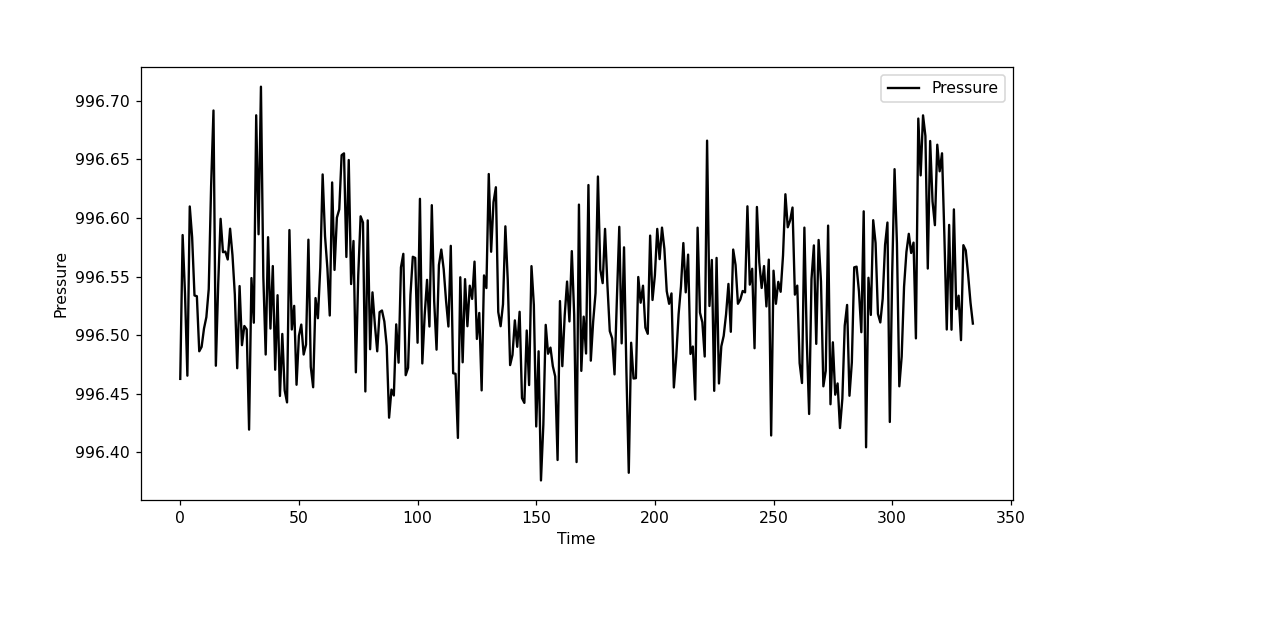

Stopped by user


In [20]:
runtest(save=True)